In [34]:
from cleanlab_studio import Studio
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
with open('api.txt') as file: 
    key = file.read()
studio = Studio(key)  # Cleanlab Studio API key from https://app.cleanlab.ai/account?tab=General
tlm = studio.TLM()

## Play with the data.

In [18]:
data = pd.read_csv('data/international_citizenship_questions/train.tsv', sep='\t')
print('Example question:\n\n' + data['question'][0], end='\n\n')

print('Example answer:\n\n' + data['answer'][0], end='\n\n')
data

Example question:

Consider the country of Afghanistan. Does the country permit a parent to confer his or her citizenship on a child born in the territory of the country of citizenship and, if so, under which conditions?

Example answer:

Yes



,index,question,answer
0,0,Consider the country of Afghanistan. Does the ...,Yes
1,1,Consider the country of Bolivia. Does the coun...,Yes
2,2,Consider the country of Bhutan. Does the count...,No
3,3,Consider the country of Zimbabwe. Does the cou...,No


In [19]:
q = data['question'][0]

In [20]:
prompt_context = 'Please answer using only the two words, "Yes" or "No" with no punctuation.'

In [21]:
output = tlm.prompt(q + " " + prompt_context)

In [22]:
print(output)

{'response': 'Yes', 'confidence_score': 0.6513994456537767}


## Load responses
See the `run-tlm-on-500dataset.ipynb` notebook for the for-loop to get TLM responses on the first 350 examples.

In [60]:
# Read in TLM results
r = pd.read_csv('tlm_results.csv')
r.columns = ['index', 'question', 'answer', 'tlm_response', 'tlm_confidence_score']
# Read in base results
br = pd.read_csv('base_results.csv')[:len(r)]
br.columns = ['index', 'question', 'answer', 'base_response', 'base_confidence_score']

## Combine base responses and tlm responses

In [123]:
r['base_response'] = br['base_response']
r = r[['index', 'question', 'answer', 'base_response', 'tlm_response', 'tlm_confidence_score']]

In [125]:
# See where TLM differs from base model (Chat GPT3.5)
r[r['tlm_response'] != r['base_response']]

,index,question,answer,base_response,tlm_response,tlm_confidence_score
11,4901,Consider the country of Rwanda. Does the count...,Yes,Yes,No,0.542324
187,3566,Consider the country of Latvia. Does the count...,No,No,Yes,0.644474
295,5432,Consider the country of Sweden. Does the count...,Yes,Yes,No,0.216132


In [127]:
r.to_csv('tlm_and_base_results.csv', index=False)

## Analysis

Note the results here are not based on the `best` perfomrming TLM, but on the `low` performing TLM which allowed us to get results faster for the hackathon. You will get more accurate results if you use `quality_preset = "best"`.

In [128]:
r = pd.read_csv('tlm_and_base_results.csv')

In [174]:
print(f"Base Acc: ~65%")
print(f"\nTLM Acc: {sum(r['answer'] == r['tlm_response']) / len(r):.1%}")
subr = r[r['tlm_confidence_score'] > 0.3]
print(f"TLM Acc (Confidence > 0.3): {sum(subr['answer'] == subr['tlm_response']) / len(subr):.1%}")
subr = r[r['tlm_confidence_score'] > 0.5]
print(f"TLM Acc (Confidence > 0.5): {sum(subr['answer'] == subr['tlm_response']) / len(subr):.1%}")
subr = r[r['tlm_confidence_score'] > 0.7]
print(f"TLM Acc (Confidence > 0.8): {sum(subr['answer'] == subr['tlm_response']) / len(subr):.1%}")

print('\nFor comparison:')

subr = r[r['tlm_confidence_score'] < 0.5]
print(f"Base (Open-AI GPT-3.5) Acc (TLM Confidence < 0.5): {sum(subr['answer'] == subr['base_response']) / len(subr):.1%}")

Base Acc: ~65%

TLM Acc: 65.5%
TLM Acc (Confidence > 0.3): 66.2%
TLM Acc (Confidence > 0.5): 69.9%
TLM Acc (Confidence > 0.8): 74.0%

For comparison:
Base (Open-AI GPT-3.5) Acc (TLM Confidence < 0.5): 55.1%


In [164]:
subr = r[r['tlm_confidence_score'] < 0.3]
print(f"Base Acc (Confidence < 0.3): {sum(subr['answer'] == subr['base_response']) / len(subr):.1%}")
subr = r[r['tlm_confidence_score'] < 0.7]
print(f"Base Acc (Confidence < 0.3): {sum(subr['answer'] == subr['base_response']) / len(subr):.1%}")


Base Acc (Confidence < 0.3): 62.5%
Base Acc (Confidence < 0.3): 55.1%
Base Acc (Confidence < 0.3): 61.6%


Text(0.5, 1.0, 'TLM Confidence scores when LLM disagrees with true answer')

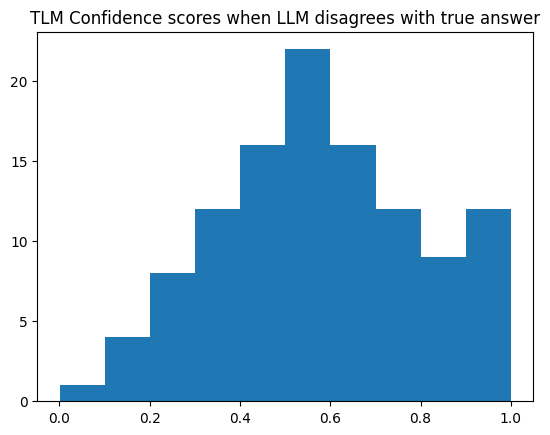

In [136]:
plt.hist(r[r['answer'] != r['tlm_response']]['tlm_confidence_score'])
plt.title('TLM Confidence scores when LLM disagrees with true answer')

Text(0.5, 1.0, 'TLM Confidence scores when LLM disagrees with true answer')

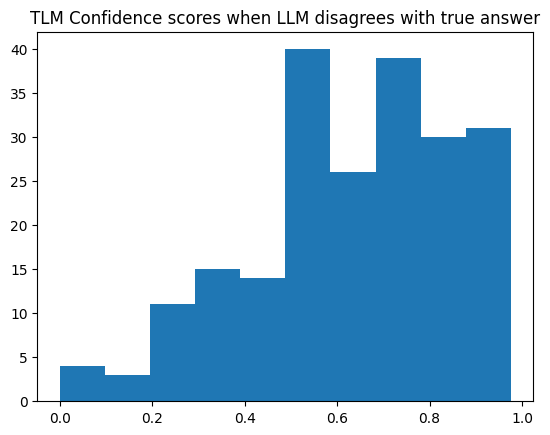

In [137]:
plt.hist(r[r['answer'] == r['tlm_response']]['tlm_confidence_score'])
plt.title('TLM Confidence scores when LLM disagrees with true answer')

## Asserts

In [113]:
# Make sure all answers are properly formatted.
assert(br['base_response'].isin(['No', 'Yes']).sum() == len(br))
assert(r['tlm_response'].isin(['No', 'Yes']).sum() == len(r))